In [1]:
import pandas as pd

In [2]:
def compute_precision_recall(df, threshold=0.5):
    # Apply threshold to prediction probabilities to classify as positive (1) or negative (0)
    df['pred_label'] = (df['pred'] >= threshold).astype(int)
    
    # Group by 'antenna' and calculate TP, FP, TN, FN, and total count
    metrics = df.groupby('antenna').apply(lambda x: pd.Series({
        'TP': ((x['label'] == 1) & (x['pred_label'] == 1)).sum(),
        'FP': ((x['label'] == 0) & (x['pred_label'] == 1)).sum(),
        'TN': ((x['label'] == 0) & (x['pred_label'] == 0)).sum(),
        'FN': ((x['label'] == 1) & (x['pred_label'] == 0)).sum(),
        'Total Count': x.shape[0]  # Total number of samples for each antenna
    })).reset_index()
    
    # Calculate Precision and Recall
    metrics['Precision'] = metrics['TP'] / (metrics['TP'] + metrics['FP'])
    metrics['Recall'] = metrics['TP'] / (metrics['TP'] + metrics['FN'])
    
    return metrics[['antenna', 'Precision', 'Recall', 'Total Count']].sort_values(by='Total Count', ascending=False)

In [3]:
df = pd.read_csv('test_images/metadata.csv')

In [4]:
df

,antenna,label,pred,datetime,image_path
0,SWISS-Landschlacht_62,1,0.950488,2022-07-05 04:00:00,test_images/1/950_SWISS-Landschlacht_62_2022-0...
1,ALMATY_58,1,0.972529,2022-06-17 02:10:00,test_images/1/972_ALMATY_58_2022-06-17_02_10_0...
2,SWISS-Landschlacht_62,1,0.809053,2022-05-03 07:04:00,test_images/1/809_SWISS-Landschlacht_62_2022-0...
3,ALASKA-HAARP_62,1,0.382440,2023-05-05 03:54:00,test_images/1/382_ALASKA-HAARP_62_2023-05-05_0...
4,ALASKA-COHOE_63,1,0.979604,2023-08-14 23:37:00,test_images/1/979_ALASKA-COHOE_63_2023-08-14_2...
...,...,...,...,...,...
5071,ALMATY_58,0,0.029277,2021-04-23 02:19:00,test_images/0/29_ALMATY_58_2021-04-23_02_19_00...
5072,TRIEST_57,0,0.547381,2023-07-09 13:23:00,test_images/0/547_TRIEST_57_2023-07-09_13_23_0...
5073,ALASKA-HAARP_62,0,0.034275,2022-09-12 04:39:00,test_images/0/34_ALASKA-HAARP_62_2022-09-12_04...
5074,ALASKA-HAARP_62,0,0.027301,2022-08-31 18:07:00,test_images/0/27_ALASKA-HAARP_62_2022-08-31_18...


In [5]:
# Compute precision and recall
precision_recall_table = compute_precision_recall(df)
precision_recall_table

/tmp/ipykernel_5385/3959170537.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df.groupby('antenna').apply(lambda x: pd.Series({


,antenna,Precision,Recall,Total Count
11,HUMAIN_59,0.352632,0.943662,418
6,Australia-ASSA_62,0.861905,0.918782,413
1,ALASKA-HAARP_62,0.780347,0.957447,387
10,GLASGOW_01,0.794737,0.926380,343
23,SWISS-Landschlacht_62,0.775510,0.904762,342
0,ALASKA-COHOE_63,0.816901,0.950820,323
4,AUSTRIA-UNIGRAZ_01,0.679104,0.919192,303
13,INDIA-OOTY_02,0.492424,0.902778,276
7,BIR_01,0.627907,0.952941,270
9,GERMANY-DLR_63,0.816514,0.946809,231


In [15]:
precision_recall_table[precision_recall_table.Precision > 0.75].antenna.to_list()

['Australia-ASSA_62',
 'ALASKA-HAARP_62',
 'GLASGOW_01',
 'SWISS-Landschlacht_62',
 'ALASKA-COHOE_63',
 'GERMANY-DLR_63',
 'USA-ARIZONA-ERAU_01',
 'ALMATY_58',
 'Australia-ASSA_02',
 'ALGERIA-CRAAG_59',
 'MEXICO-LANCE-B_62']

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


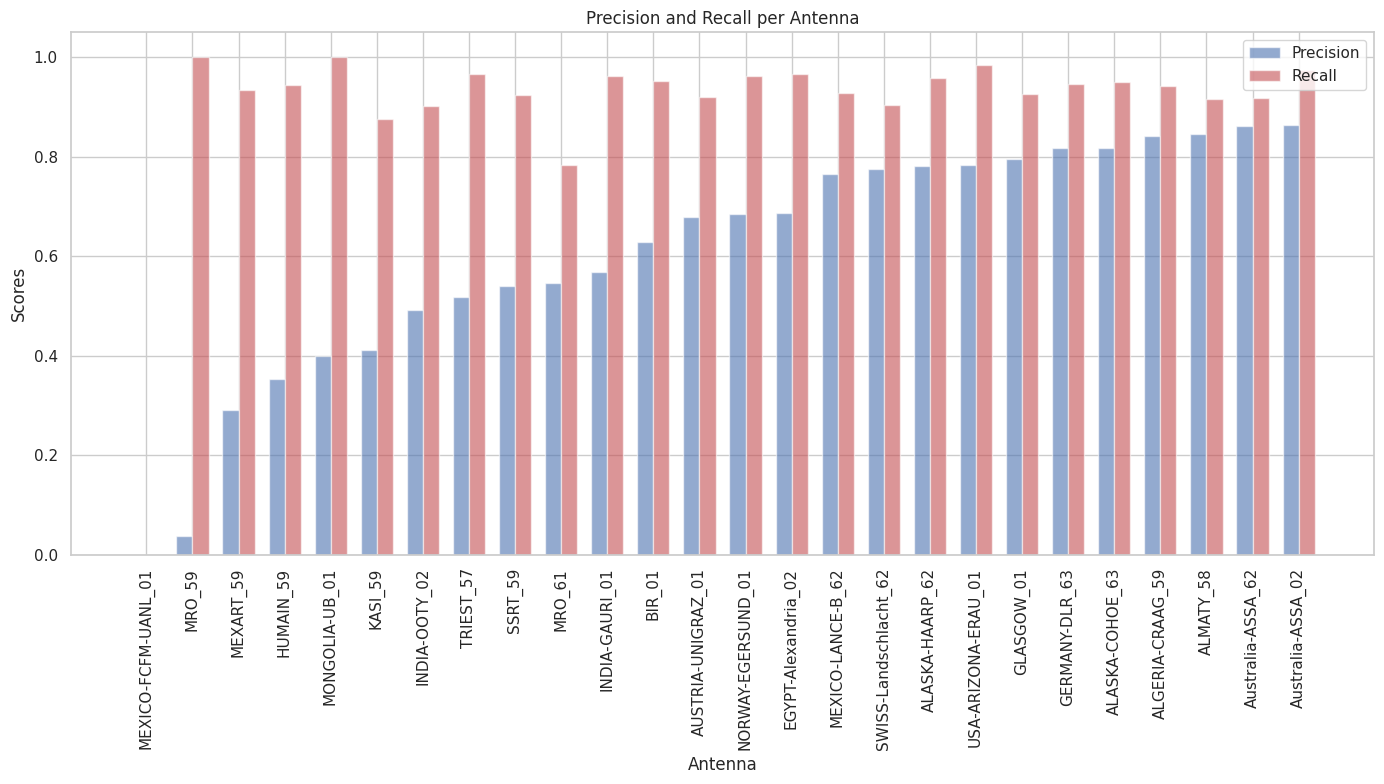

In [12]:
# Plot
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

df = precision_recall_table.sort_values(by='Precision')
# Create a bar plot for Precision and Recall
bar_width = 0.35
bar_positions = range(len(df))

plt.bar(bar_positions, df['Precision'], bar_width, label='Precision', color='b', alpha=0.6)
plt.bar([p + bar_width for p in bar_positions], df['Recall'], bar_width, label='Recall', color='r', alpha=0.6)

# Add labels and title
plt.xlabel('Antenna')
plt.ylabel('Scores')
plt.title('Precision and Recall per Antenna')
plt.xticks([p + bar_width/2 for p in bar_positions], df['antenna'], rotation=90)
plt.legend()

# Display plot
plt.tight_layout()
plt.show()